In [2]:
import sys
import scipy.io
import scipy.signal as sig
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

### Load the CinC training dataset

In [2]:
# Start by loading the data

training_path = "CinC2017Data/training2017/training2017/"
answers_path = "CinC2017Data/REFERENCE-v3.csv"

dataset = pd.read_csv(answers_path, header=None, names=["class"], index_col=0)
dataset["data"] = None

print(dataset.head())

for root, dirs, files in os.walk(training_path):
    for name in files:
        try:
            name, ext = name.split(".")
        except ValueError:
            print("error, scipping file")
            continue
        if ext == "mat":
            mat_data = scipy.io.loadmat(os.path.join(root, name+"."+ext))
            dataset.loc[name]["data"] = mat_data["val"]
            print(f"Adding {name}\r", end="")
            
print(dataset.head())
pk_path = "CinC2017Data/database.pk"
dataset.to_pickle(pk_path)

       class  data
A00001     N  None
A00002     N  None
A00003     N  None
A00004     A  None
A00005     A  None
error, scipping file
       class                                               data
A00001     N  [[-127, -162, -197, -229, -245, -254, -261, -2...
A00002     N  [[128, 157, 189, 226, 250, 257, 262, 265, 268,...
A00003     N  [[56, 73, 85, 93, 100, 107, 113, 117, 118, 117...
A00004     A  [[519, 619, 723, 827, 914, 956, 955, 934, 920,...
A00005     A  [[-188, -239, -274, -316, -356, -374, -380, -3...


In [3]:
dataset = pd.read_pickle("CinC2017Data/database.pk")

In [4]:
dataset["length"] = dataset["data"].map(lambda arr: arr.shape[-1])

In [5]:
# select only the 30s length records
dataset = dataset[dataset["length"] == 9000]

In [6]:
import torch.nn as nn
import torch

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [8]:
# Check cuda
print(torch.cuda.is_available())

True


In [94]:
# Now define a model

class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()

        self.conv_section1 = nn.Sequential(
            nn.Conv1d(1, 128, 16, stride=4),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(128)
        )

        self.conv_section2 = nn.Sequential(
            nn.Conv1d(128, 256, 11, stride=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(256)
        )

        self.conv_section3 = nn.Sequential(
            nn.Conv1d(256, 256, 3),
            nn.ReLU(),
            nn.Conv1d(256, 256, 3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(256)
        )

        self.conv_section4 = nn.Sequential(
            nn.Conv1d(256, 128, 3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(128)
        )

        self.conv_section5 = nn.Sequential(
            nn.Conv1d(128, 64, 3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(64)
        )

        self.conv_section6 = nn.Sequential(
            nn.Conv1d(64, 32, 3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(32)
        )

        self.lstm = nn.LSTM(input_size=32, hidden_size=32, bidirectional=False, batch_first=True)

        # self.dense1 = nn.Linear(352, 128)
        self.dense2 = nn.Linear(480, 64)
        self.dense3 = nn.Linear(64, 4)

        self.activation = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=-1)

        self.dropout = nn.Dropout()

    def forward(self, x):

        # [1, 9000]
        x = self.conv_section1(x)

        # [512, 4499]
        x = self.conv_section2(x)

        # [256, 2249]
        x = self.conv_section3(x)

        # [128, 1124]
        x = self.conv_section4(x)

        # [64, 561]
        x = self.conv_section5(x)

        # [32, 280]
        x = self.conv_section6(x)

        # [32, 139]
        x = torch.transpose(x, 1, 2)

        x, _ = self.lstm(x)
        x = torch.flatten(x, 1, -1)

        # [1024]
        x = self.dense2(x)
        x = self.activation(x)
        x = self.dropout(x)

        # [128]
        x = self.dense3(x)
        x = self.logsoftmax(x)

        # [4]
        return x

In [95]:
# Onehot encoding
from torch.utils.data import Dataset, DataLoader

def generate_onehot(c):
    if c == "N":
        return np.array([1, 0, 0, 0])
    if c == "O":
        return np.array([0, 1, 0, 0])
    if c == "A":
        return np.array([0, 0, 1, 0])
    if c == "~":
        return np.array([0, 0, 0, 1])

def generate_index(c):
    if c == "N":
        return 0
    if c == "O":
        return 1
    if c == "A":
        return 2
    if c == "~":
        return 3

# dataset["onehot"] = dataset["class"].map(generate_onehot)
dataset["class_index"] = dataset["class"].map(generate_index)

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, dataset):
        'Initialization'
        self.dataset = dataset

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.dataset.index)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.dataset.iloc[index]

        X = row["data"][0]
        y = row["class_index"]

        return X, y

train_dataset, test_dataset = train_test_split(dataset, test_size=0.15, stratify=dataset["class"])

torch_dataset_train = Dataset(train_dataset)
torch_dataset_test = Dataset(test_dataset)

train_dataloader = DataLoader(torch_dataset_train, batch_size=32, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(torch_dataset_test, batch_size=32, shuffle=True, pin_memory=True)

In [96]:
num_epochs = 10

if torch.cuda.is_available():
    print("Using Cuda")
    device = torch.device("cuda")
else:
    print("Using CPU")
    device = torch.device("cpu")

model = CNN().to(device)

# Use weightings to avoid

class_counts = torch.tensor(dataset["class"].value_counts().values.astype(np.float32))
class_weights = torch.nn.functional.normalize(1.0/class_counts, dim=0)
loss_func = torch.nn.NLLLoss(class_weights)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.8)
num_batches = len(train_dataloader)
num_test_batches = len(test_dataloader)

Using Cuda


In [98]:

model = model.to(device)

for epoch in range(num_epochs):
    total_loss = 0
    print(f"starting epoch {epoch} ...")
    # Train
    model.train()
    for i, (signals, labels) in enumerate(train_dataloader):
        signals = torch.unsqueeze(signals.to(device), 1).float()
        # fft = torch.abs(torch.fft.fft(signals))
        # signals = torch.cat([signals, fft], dim=1)
        labels = labels.type(torch.LongTensor)

        optimizer.zero_grad()
        output = model(signals).to("cpu")
        loss = loss_func(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += float(loss)

    print(f"Epoch {epoch} finished with average loss {total_loss/num_batches}")
    print("Testing ...")
    # Test
    test_loss = 0
    with torch.no_grad():
        model.eval()
        for i, (signals, labels) in enumerate(test_dataloader):
            signals = torch.unsqueeze(signals.to(device), 1).float()
            # fft = torch.abs(torch.fft.fft(signals))
            # signals = torch.cat([signals, fft], dim=1)
            labels = labels.type(torch.LongTensor)

            output = model(signals).to("cpu")
            loss = loss_func(output, labels)
            test_loss += float(loss)

    print(f"Average test loss: {test_loss/num_test_batches}")

starting epoch 0 ...
Epoch 0 finished with average loss 0.6859894479220768
Testing ...
Average test loss: 0.7185777251062722
starting epoch 1 ...
Epoch 1 finished with average loss 0.6170178366906988
Testing ...
Average test loss: 0.7240210452984119
starting epoch 2 ...
Epoch 2 finished with average loss 0.5887409171218392
Testing ...
Average test loss: 0.6013911289387736
starting epoch 3 ...
Epoch 3 finished with average loss 0.5483386453779988
Testing ...
Average test loss: 0.6763498505641674
starting epoch 4 ...
Epoch 4 finished with average loss 0.5056678131691315
Testing ...
Average test loss: 0.6839364489604687
starting epoch 5 ...


KeyboardInterrupt: 

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

In [99]:
model.eval()

true_labels = []
predictions = []

with torch.no_grad():
    for i, (signals, labels) in enumerate(test_dataloader):
        signals = torch.unsqueeze(signals.to(device), 1).float()
        # fft = torch.abs(torch.fft.fft(signals))
        # signals = torch.cat([signals, fft], dim=1)
        labels = labels.detach().numpy()
        true_labels.append(labels)

        optimizer.zero_grad()
        output = model(signals).detach().to("cpu").numpy()
        predictions.append(np.argmax(output, axis=-1))

predictions = np.concatenate(predictions)
true_labels = np.concatenate(true_labels)

Normal F1: 0.8348968105065666
Other F1: 0.6008583690987125
AF F1: 0.6774193548387096
Noisy F1: 0.4473684210526316
Average F1 score: 0.640135738874155


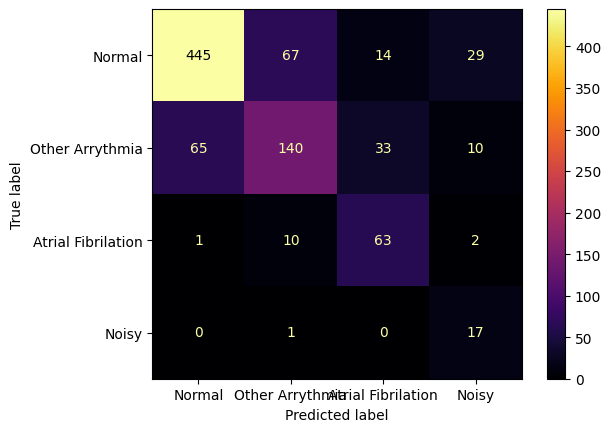

In [100]:
ConfusionMatrixDisplay.from_predictions(true_labels, predictions, display_labels=["Normal", "Other Arrythmia", "Atrial Fibrilation", "Noisy"], cmap="inferno")

conf_mat = confusion_matrix(true_labels, predictions)

def F1_ind(conf_mat, ind):
    return (2 * conf_mat[ind, ind])/(np.sum(conf_mat[ind]) + np.sum(conf_mat[:, ind]))

print(f"Normal F1: {F1_ind(conf_mat, 0)}")
print(f"Other F1: {F1_ind(conf_mat, 1)}")
print(f"AF F1: {F1_ind(conf_mat, 2)}")
print(f"Noisy F1: {F1_ind(conf_mat, 3)}")

print(f"Average F1 score: {sum([F1_ind(conf_mat, i) for i in range(4)])/4}")

In [43]:
# Save a model
torch.save(model.state_dict(), "TrainedModels/CNN_AlexNet.pt")

In [23]:
# Garbage collection - in case of CUDA out of memory error
import gc
model = None
signals = None
labels = None
gc.collect() # Python thing
torch.cuda.empty_cache()